<a href="https://colab.research.google.com/github/saif619/MachineLearningPython/blob/master/NaturalDisaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
#for file1 in file_list:
#  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [0]:
downloaded = drive.CreateFile({'id': '1NvTyhUsrFbL91E10EPm38IjoCg6E2c6q'})
downloaded.GetContentFile('Cyclone_Wildfire_Flood_Earthquake_Database.zip')

In [0]:
downloaded = drive.CreateFile({'id':'1TPCqv2H5mOpTycNBfJ3dqLbbJSQwV_e2'})
downloaded.GetContentFile('NaturalDisaster_14Nov.h5')

In [7]:
import os
os.listdir()

['.config',
 'NaturalDisaster_14Nov.h5',
 'Cyclone_Wildfire_Flood_Earthquake_Database.zip',
 'gdrive',
 'adc.json',
 'sample_data']

In [8]:
!unzip Cyclone_Wildfire_Flood_Earthquake_Database.zip

Archive:  Cyclone_Wildfire_Flood_Earthquake_Database.zip
   creating: Cyclone_Wildfire_Flood_Earthquake_Database/
   creating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/0.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/1.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/10.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/100.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/101.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/102.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/103.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/104.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/105.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/106.jpg  
  inflating: Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/107.jpg  
  inflating:

In [0]:
DATASET_PATH = "Cyclone_Wildfire_Flood_Earthquake_Database"
 
# initialize the class labels in the dataset
CLASSES = ["Cyclone", "Earthquake", "Flood", "Wildfire"]

In [11]:
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import sys
import os

In [12]:

print("[INFO] loading images...")
imagePaths = list(paths.list_images(DATASET_PATH))
data = []
labels = []

[INFO] loading images...


In [13]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label
	label = imagePath.split(os.path.sep)[-2]
 
	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
 
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
 
# convert the data and labels to NumPy arrays
print("[INFO] processing data...")
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

[INFO] processing data...


In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
 
# take the validation split from the training split
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size=0.1, random_state=84)
 
# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [47]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
 
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
 
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False
 
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=1e-03, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [0]:
#model.summary()

In [0]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


filepath = "/content/gdrive/My Drive/naturalDisaster-weights-{epoch:02d}-{val_acc:.4f}.h5"
callbacks = [
            ReduceLROnPlateau(), 
            EarlyStopping(patience=4), 
            ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                    save_weights_only=True, 
                    mode='auto', period=3, save_best_only=False)
            ]

In [50]:
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=aug.flow(valX, valY),
	validation_steps=len(valX) // 32,
	epochs=10)

Epoch 1/10
99/99 [==============================] - 38s 381ms/step - loss: 8.4044 - acc: 0.6818 - val_loss: 0.7198 - val_acc: 0.8068
Epoch 2/10
99/99 [==============================] - 37s 376ms/step - loss: 0.9403 - acc: 0.7258 - val_loss: 0.5324 - val_acc: 0.8267
Epoch 3/10
99/99 [==============================] - 37s 375ms/step - loss: 0.7804 - acc: 0.7410 - val_loss: 0.4957 - val_acc: 0.8295
Epoch 4/10
99/99 [==============================] - 37s 370ms/step - loss: 0.6306 - acc: 0.7803 - val_loss: 0.5778 - val_acc: 0.8466
Epoch 5/10
99/99 [==============================] - 36s 364ms/step - loss: 0.6290 - acc: 0.7845 - val_loss: 0.4397 - val_acc: 0.8580
Epoch 6/10
99/99 [==============================] - 36s 361ms/step - loss: 0.5662 - acc: 0.8089 - val_loss: 0.4264 - val_acc: 0.8381
Epoch 7/10
99/99 [==============================] - 36s 360ms/step - loss: 0.5334 - acc: 0.8086 - val_loss: 0.4100 - val_acc: 0.8636
Epoch 8/10
99/99 [==============================] - 36s 361ms/step - 

In [0]:
model.save_weights("/content/gdrive/My Drive/NaturalDisaster_14Nov.h5")

In [0]:
#model.load_weights('NaturalDisaster_14Nov.h5')

In [61]:
z = 100
print(CLASSES)
print(testY[z])

['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
[0 1 0 0]


In [62]:
pred = model.predict(np.expand_dims(testX[z], axis=0))[0]
print(np.argmax(pred)+1)

2


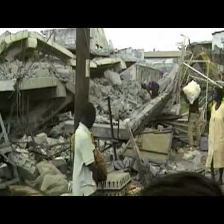

In [63]:
from google.colab.patches import cv2_imshow
cv2_imshow(testX[z])